In [1]:
# Import libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
from matplotlib import pyplot as plt

In [2]:
# Get the medal details dataset
df_medal_details = pd.read_csv('../data/etl/medals_by_season_country_discip_event_type.csv')
df_medal_details.head()

,game_season,country_code,country_name,discipline_title,event_title,event_gender,medal_type,medal_count
0,Summer,AFG,Afghanistan,Taekwondo,58 - 68 kg men,Men,BRONZE,1
1,Summer,AFG,Afghanistan,Taekwondo,beijing 2008 taekwondo - 58 kg men,Men,BRONZE,1
2,Summer,AHO,Netherlands Antilles,Sailing,division ii - windsurfer men,Open,SILVER,1
3,Summer,ALG,Algeria,Athletics,1500m men,Men,GOLD,2
4,Summer,ALG,Algeria,Athletics,1500m men,Men,SILVER,1


In [10]:
# Get all of the other datasets in the etl folder
df_hapiness = pd.read_csv('../data/etl/happiness_avg_by_country.csv')
df_gdp = pd.read_csv('../data/etl/gdp_avg_by_country.csv')
df_nutrition = pd.read_csv('../data/etl/nutrition_2017_by_country.csv')

In [17]:
# Function to merge a medals slice with the other datasets
def merge_hap_gdp_nut(df_medal_slice: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(df_medal_slice, df_hapiness, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_gdp, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_nutrition, on='country_name', how='left')
    df_merged = df_merged.drop(columns=['country_code']).reset_index(drop=True)
    return df_merged

In [18]:
# Function to slice the medal details dataset and prepare it for correlation
def slice_medal_details_data(data_to_select: dict[str, str]) -> pd.DataFrame:
    drop_medal_cols = ['game_season', 'country_code', 'discipline_title', 'event_title', 'event_gender', 'medal_type']
    group_medal_cols = ['country_name']

    df_slice = df_medal_details.copy()
    for key, value in data_to_select.items():
        df_slice = df_slice[df_slice[key] == value]

    df_slice = df_slice.drop(columns=drop_medal_cols)
    df_slice = df_slice.groupby(group_medal_cols)['medal_count'].sum().reset_index()
    return df_slice.reset_index(drop=True)

In [19]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    # Use pandas to find potential outliers by calculating the interquartile range (IQR)
    medals = df['medal_count']
    Q1 = medals.quantile(0.25)
    median = medals.quantile(0.5)
    Q3 = medals.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (2 * IQR)
    upper_bound = Q3 + (2 * IQR)
    return lower_bound, upper_bound


In [20]:
def custom_outliers(df: pd.DataFrame) -> pd.DataFrame:
    # Use pandas to find potential outliers by calculating the interquartile range (IQR)
    medals = df['medal_count']
    Q1 = medals.quantile(0.25)
    median = medals.quantile(0.5)
    Q3 = medals.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 * 5
    upper_bound = df['medal_count'].max()
    return lower_bound, upper_bound


In [21]:
def box_plot_medals(df: pd.DataFrame, title: str) -> None:
    medals = df['medal_count']
    fig1, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.set_ylabel('Medal Count')
    ax1.boxplot(medals)
    plt.show()

In [22]:
# Women's summer games correlation
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.234169,0.292613,0.196042,0.175230,0.106811,0.088550,-0.097630,0.116056,-0.183149,0.831738,-0.143459,-0.234326,0.287825,-0.269807,-0.057799,-0.038258,-0.022957,0.313934
happiness,0.234169,1.000000,0.802930,0.733222,0.756080,0.603387,0.386329,-0.605655,0.577287,-0.283254,0.208903,-0.484953,-0.669611,0.745038,-0.729592,-0.229837,-0.256168,-0.258314,-0.178541
wealth,0.292613,0.802930,1.000000,0.699171,0.845801,0.423534,0.143712,-0.459858,0.274619,-0.214183,0.228058,-0.612861,-0.865180,0.897316,-0.890775,-0.291909,-0.257796,-0.255224,-0.159272
support,0.196042,0.733222,0.699171,1.000000,0.576696,0.410272,0.248135,-0.311162,0.434188,-0.373286,0.121385,-0.577305,-0.662909,0.681071,-0.669299,-0.271962,-0.387809,-0.388383,-0.281999
health,0.175230,0.756080,0.845801,0.576696,1.000000,0.343019,0.117758,-0.402794,0.259747,-0.115918,0.156748,-0.693061,-0.858314,0.861120,-0.852608,-0.395448,-0.246540,-0.234429,-0.104271
freedom,0.106811,0.603387,0.423534,0.410272,0.343019,1.000000,0.515688,-0.573057,0.667536,-0.314624,0.141292,-0.373247,-0.294319,0.320800,-0.327405,-0.107521,0.022830,0.028156,0.075831
generosity,0.088550,0.386329,0.143712,0.248135,0.117758,0.515688,1.000000,-0.402282,0.485264,-0.229358,0.089769,0.016268,0.068726,-0.099554,0.078555,0.099882,0.079477,0.080184,-0.011830
corruption,-0.097630,-0.605655,-0.459858,-0.311162,-0.402794,-0.573057,-0.402282,1.000000,-0.354051,0.365717,-0.073937,0.185118,0.296763,-0.346231,0.359692,0.157578,0.112959,0.115466,0.117395
positivity,0.116056,0.577287,0.274619,0.434188,0.259747,0.667536,0.485264,-0.354051,1.000000,-0.221380,0.180355,-0.028703,-0.048681,0.102016,-0.104424,0.077406,-0.051929,-0.050387,0.010820
negativity,-0.183149,-0.283254,-0.214183,-0.373286,-0.115918,-0.314624,-0.229358,0.365717,-0.221380,1.000000,-0.073840,0.047232,0.230614,-0.202909,0.229632,0.030505,0.160355,0.147798,-0.006197


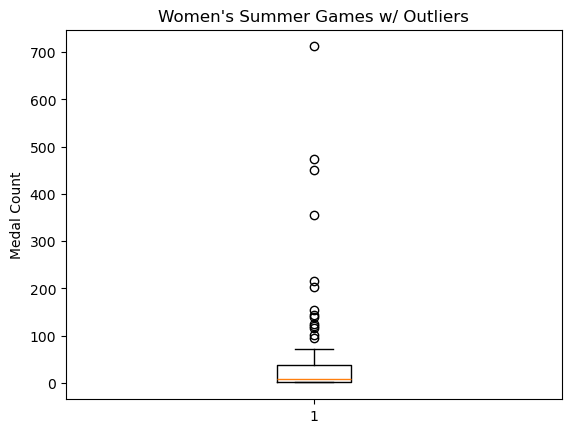

In [23]:
# Create a boxplot to visualize the filtered dataset
box_plot_medals(df, 'Women\'s Summer Games w/ Outliers')


In [26]:
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
0,United States,712,7.029156,10.976059,0.915736,66.399999,0.829080,0.182304,0.690821,0.752731,0.264086,8536365.96,1.2,1.5,98.0,2.0,4.1,4.9,6.5,325122.128
1,Russia,473,5.564873,10.148258,0.897139,62.349999,0.679709,-0.193543,0.883493,0.590380,0.180509,1062108.61,0.0,1.0,96.0,4.0,0.0,1.4,5.7,144496.739
2,Germany,451,6.822410,10.824794,0.919011,70.448889,0.858239,0.080415,0.558557,0.698333,0.206088,1857701.61,0.0,0.2,99.8,0.2,0.0,0.2,0.2,82657.002
3,China,356,5.160455,9.340597,0.789619,67.525000,0.843813,-0.154764,NaN,0.691941,0.170754,3291242.38,0.2,8.0,85.7,14.3,2.3,111.7,199.3,1396215.000
4,Australia,216,7.242307,10.764977,0.942319,70.570588,0.914413,0.254107,0.429199,0.737576,0.218661,521918.13,0.2,0.5,99.3,0.7,0.1,0.1,0.2,24601.860


,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
98,Samoa,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,Vietnam,1,5.437579,8.977185,0.827434,64.900000,0.898700,-0.024657,0.771082,0.623233,0.204675,NaN,1.3,15.9,67.6,32.4,1.2,15.1,30.7,94600.643
100,Fiji,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994.08,0.3,26.9,48.5,51.5,0.0,0.2,0.5,877.460
101,Iceland,1,7.467971,10.882743,0.978552,71.865909,0.929938,0.253598,0.696472,0.805332,0.165813,8909.10,0.0,0.0,NaN,0.0,0.0,0.0,0.0,343.400
102,Latvia,1,5.569637,10.204665,0.886316,65.305882,0.673703,-0.113089,0.856114,0.598389,0.220305,23121.80,0.2,1.7,96.6,3.4,0.0,0.0,0.1,1942.248


10.0 712


,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
0,United States,712,7.029156,10.976059,0.915736,66.399999,0.829080,0.182304,0.690821,0.752731,0.264086,8536365.96,1.2,1.5,98.0,2.0,4.1,4.9,6.5,325122.128
1,Russia,473,5.564873,10.148258,0.897139,62.349999,0.679709,-0.193543,0.883493,0.590380,0.180509,1062108.61,0.0,1.0,96.0,4.0,0.0,1.4,5.7,144496.739
2,Germany,451,6.822410,10.824794,0.919011,70.448889,0.858239,0.080415,0.558557,0.698333,0.206088,1857701.61,0.0,0.2,99.8,0.2,0.0,0.2,0.2,82657.002
3,China,356,5.160455,9.340597,0.789619,67.525000,0.843813,-0.154764,NaN,0.691941,0.170754,3291242.38,0.2,8.0,85.7,14.3,2.3,111.7,199.3,1396215.000
4,Australia,216,7.242307,10.764977,0.942319,70.570588,0.914413,0.254107,0.429199,0.737576,0.218661,521918.13,0.2,0.5,99.3,0.7,0.1,0.1,0.2,24601.860


,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
42,Azerbaijan,13,4.935251,9.527749,0.760488,62.507812,0.681153,-0.158288,0.693731,0.518247,0.240791,30686.34,0.0,0.0,NaN,0.0,0.0,0.0,0.0,9854.033
43,Argentina,13,6.289722,10.028808,0.901894,66.700000,0.777786,-0.153203,0.839019,0.737995,0.288382,317986.22,0.3,7.1,89.0,11.0,0.1,3.1,4.8,44044.811
44,Nigeria,12,4.983039,8.490657,0.758219,53.031250,0.688673,0.075431,0.896963,0.734424,0.232661,160300.71,55.3,78.1,5.9,94.1,105.6,149.0,179.7,190873.247
45,Turkey,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,Finland,11,7.624132,10.761079,0.951761,70.442501,0.942584,0.001391,0.237706,0.737589,0.185152,125374.08,0.1,0.1,99.9,0.1,0.0,0.0,0.0,5508.214


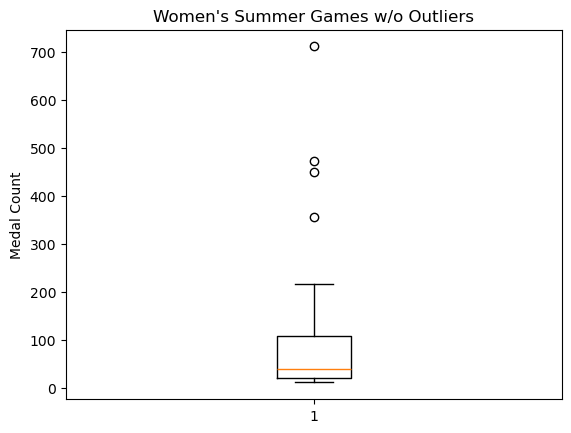

In [27]:
# Remove outliers
lower, upper = custom_outliers(df)
print(lower, upper)

# Remove outliers
outlier_df = df[(df['medal_count'] <= upper) & (df['medal_count'] > lower)]

display(outlier_df.head())
display(outlier_df.tail())
box_plot_medals(outlier_df, 'Women\'s Summer Games w/o Outliers')


In [28]:
outlier_df.set_index('country_name').corr()


,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.116977,0.256863,0.117174,0.110055,0.072432,0.050246,-0.009606,-0.002512,-0.113689,0.815994,-0.169451,-0.251815,0.273072,-0.249579,-0.111027,-0.050634,0.003153,0.414748
happiness,0.116977,1.000000,0.828885,0.724061,0.720085,0.681972,0.393999,-0.804569,0.623039,-0.169032,0.158334,-0.429233,-0.620542,0.675886,-0.636694,-0.309395,-0.490938,-0.473662,-0.231662
wealth,0.256863,0.828885,1.000000,0.804616,0.802939,0.457908,0.122186,-0.596359,0.256261,-0.180996,0.227591,-0.552595,-0.839035,0.882943,-0.858617,-0.445311,-0.662653,-0.618709,-0.236446
support,0.117174,0.724061,0.804616,1.000000,0.605120,0.309192,0.189664,-0.575817,0.334784,-0.177394,0.072496,-0.481482,-0.694875,0.785914,-0.713188,-0.419864,-0.670309,-0.646673,-0.324710
health,0.110055,0.720085,0.802939,0.605120,1.000000,0.327973,0.103831,-0.515027,0.199000,-0.024981,0.136623,-0.726203,-0.804079,0.806936,-0.782673,-0.572012,-0.586065,-0.506436,-0.095583
freedom,0.072432,0.681972,0.457908,0.309192,0.327973,1.000000,0.579382,-0.763709,0.712786,-0.410138,0.128710,-0.269966,-0.283243,0.292183,-0.277756,-0.219424,-0.166948,-0.128416,0.018122
generosity,0.050246,0.393999,0.122186,0.189664,0.103831,0.579382,1.000000,-0.450333,0.607381,-0.184958,0.060944,0.059786,0.120637,-0.147009,0.151507,0.087701,0.174794,0.166749,-0.084895
corruption,-0.009606,-0.804569,-0.596359,-0.575817,-0.515027,-0.763709,-0.450333,1.000000,-0.483310,0.452021,-0.022307,0.270601,0.410821,-0.437818,0.443294,0.214452,0.312636,0.319042,0.312879
positivity,-0.002512,0.623039,0.256261,0.334784,0.199000,0.712786,0.607381,-0.483310,1.000000,-0.167790,0.158466,0.100793,0.081417,-0.066558,0.085662,0.100130,0.108324,0.107986,0.049134
negativity,-0.113689,-0.169032,-0.180996,-0.177394,-0.024981,-0.410138,-0.184958,0.452021,-0.167790,1.000000,0.009433,0.026924,0.162065,-0.146897,0.157912,0.030455,0.037728,-0.007741,-0.141381


In [29]:
# Men's summer games correlation
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.302195,0.323346,0.268885,0.241091,0.114720,0.105932,-0.133022,0.118270,-0.176553,0.838378,-0.142282,-0.280642,0.335520,-0.318831,-0.047889,-0.055645,-0.054340,0.180862
happiness,0.302195,1.000000,0.825564,0.772157,0.756097,0.643687,0.326431,-0.571974,0.606728,-0.402249,0.220894,-0.433267,-0.701757,0.765472,-0.756928,-0.195048,-0.213951,-0.218085,-0.125130
wealth,0.323346,0.825564,1.000000,0.739491,0.807169,0.510695,0.107075,-0.472486,0.308806,-0.294710,0.219088,-0.539731,-0.857150,0.884786,-0.881313,-0.253182,-0.225109,-0.229129,-0.123776
support,0.268885,0.772157,0.739491,1.000000,0.665236,0.508845,0.154416,-0.300539,0.514180,-0.491097,0.157075,-0.488229,-0.686446,0.722369,-0.713174,-0.211678,-0.327566,-0.341140,-0.199458
health,0.241091,0.756097,0.807169,0.665236,1.000000,0.424984,0.033406,-0.350253,0.269908,-0.213947,0.180917,-0.607434,-0.849941,0.853678,-0.847442,-0.308381,-0.186599,-0.183232,-0.050545
freedom,0.114720,0.643687,0.510695,0.508845,0.424984,1.000000,0.384105,-0.538661,0.701076,-0.470892,0.145872,-0.286492,-0.362750,0.407794,-0.420478,-0.088602,0.005903,-0.001469,0.061473
generosity,0.105932,0.326431,0.107075,0.154416,0.033406,0.384105,1.000000,-0.359275,0.404347,-0.197168,0.089491,0.052033,0.080842,-0.097876,0.070070,0.096817,0.080078,0.083352,-0.002555
corruption,-0.133022,-0.571974,-0.472486,-0.300539,-0.350253,-0.538661,-0.359275,1.000000,-0.306826,0.350704,-0.073251,0.164968,0.282769,-0.310482,0.338963,0.143532,0.105055,0.109142,0.109420
positivity,0.118270,0.606728,0.308806,0.514180,0.269908,0.701076,0.404347,-0.306826,1.000000,-0.410777,0.153781,-0.023742,-0.093843,0.185542,-0.188746,0.065278,-0.063525,-0.075323,-0.006522
negativity,-0.176553,-0.402249,-0.294710,-0.491097,-0.213947,-0.470892,-0.197168,0.350704,-0.410777,1.000000,-0.104866,0.061417,0.206772,-0.233172,0.254083,0.009961,0.120201,0.119290,-0.014833


In [30]:
# Women's Winter games correlation
data_to_select = {
    'game_season': 'Winter', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.293902,0.368509,0.037328,0.116197,0.150746,0.222953,-0.145163,0.263971,-0.084173,0.497530,0.079564,-0.099632,0.100702,-0.104417,0.290103,0.016835,0.016856,0.141647
happiness,0.293902,1.000000,0.792075,0.662641,0.634085,0.758872,0.764447,-0.850618,0.852597,-0.051017,0.025073,-0.119521,-0.633608,0.702636,-0.707371,-0.110982,-0.346920,-0.352560,-0.346490
wealth,0.368509,0.792075,1.000000,0.470882,0.735045,0.393650,0.467763,-0.497312,0.557620,0.163642,0.129109,0.109893,-0.639433,0.718740,-0.719835,-0.088171,-0.568685,-0.574768,-0.528144
support,0.037328,0.662641,0.470882,1.000000,0.211843,0.589281,0.520284,-0.634704,0.551495,-0.015267,-0.222326,-0.182918,-0.804266,0.836941,-0.839390,-0.372135,-0.728041,-0.729821,-0.720401
health,0.116197,0.634085,0.735045,0.211843,1.000000,0.415683,0.366478,-0.453970,0.532648,0.215837,-0.008047,0.182279,-0.244406,0.331284,-0.346921,-0.100738,-0.126282,-0.131950,-0.161506
freedom,0.150746,0.758872,0.393650,0.589281,0.415683,1.000000,0.661999,-0.832056,0.865938,-0.390701,-0.024992,-0.311312,-0.405591,0.454209,-0.465401,-0.060174,0.014449,0.010415,-0.030746
generosity,0.222953,0.764447,0.467763,0.520284,0.366478,0.661999,1.000000,-0.712125,0.736400,-0.042847,0.068776,-0.099206,-0.380112,0.462548,-0.469253,0.000454,-0.220951,-0.228952,-0.213988
corruption,-0.145163,-0.850618,-0.497312,-0.634704,-0.453970,-0.832056,-0.712125,1.000000,-0.846062,0.463402,0.109129,0.300450,0.541084,-0.611765,0.619604,0.149623,0.287774,0.371913,0.259521
positivity,0.263971,0.852597,0.557620,0.551495,0.532648,0.865938,0.736400,-0.846062,1.000000,-0.264618,0.197765,-0.008796,-0.336374,0.404978,-0.417581,0.153213,0.016631,0.010533,0.021787
negativity,-0.084173,-0.051017,0.163642,-0.015267,0.215837,-0.390701,-0.042847,0.463402,-0.264618,1.000000,0.118946,0.328512,0.007652,0.071974,-0.051243,0.070617,-0.229317,-0.237103,-0.188366


In [31]:
# Men's Winter games correlation
data_to_select = {
    'game_season': 'Winter', 
    'event_gender': 'Men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.500560,0.441564,0.279099,0.231488,0.389217,0.357822,-0.413321,0.471113,-0.238810,0.298308,0.023987,-0.268168,0.270163,-0.280353,0.144936,-0.087052,-0.085645,-0.000049
happiness,0.500560,1.000000,0.856339,0.624554,0.672558,0.817504,0.797634,-0.872099,0.870024,-0.108964,0.069879,-0.151856,-0.599230,0.676905,-0.682786,-0.059403,-0.303637,-0.308424,-0.285016
wealth,0.441564,0.856339,1.000000,0.546730,0.711939,0.637506,0.629031,-0.716089,0.710345,-0.021521,0.081644,0.007834,-0.589106,0.668249,-0.674269,-0.074794,-0.491969,-0.496730,-0.453117
support,0.279099,0.624554,0.546730,1.000000,0.282322,0.521802,0.524934,-0.614448,0.546281,-0.115683,-0.117003,-0.314011,-0.863188,0.873523,-0.875727,-0.277409,-0.589715,-0.589481,-0.561254
health,0.231488,0.672558,0.711939,0.282322,1.000000,0.562469,0.472064,-0.565044,0.625470,0.091856,0.000946,0.096044,-0.309305,0.382018,-0.397478,-0.065305,-0.099335,-0.104055,-0.120318
freedom,0.389217,0.817504,0.637506,0.521802,0.562469,1.000000,0.659723,-0.841393,0.863265,-0.357943,0.056756,-0.297605,-0.382157,0.434220,-0.447269,-0.002449,0.043937,0.040755,0.019858
generosity,0.357822,0.797634,0.629031,0.524934,0.472064,0.659723,1.000000,-0.725571,0.746700,-0.064295,0.135831,-0.147104,-0.418003,0.489234,-0.497490,0.039442,-0.189057,-0.196086,-0.166210
corruption,-0.413321,-0.872099,-0.716089,-0.614448,-0.565044,-0.841393,-0.725571,1.000000,-0.848092,0.488381,0.037674,0.349474,0.573849,-0.647480,0.652784,0.103444,0.285103,0.346954,0.168069
positivity,0.471113,0.870024,0.710345,0.546281,0.625470,0.863265,0.746700,-0.848092,1.000000,-0.285822,0.256223,-0.069867,-0.395241,0.451907,-0.465102,0.191969,0.044593,0.039467,0.065839
negativity,-0.238810,-0.108964,-0.021521,-0.115683,0.091856,-0.357943,-0.064295,0.488381,-0.285822,1.000000,0.066866,0.394566,0.167919,-0.076707,0.096139,0.054318,-0.229022,-0.237347,-0.197667


In [32]:
# Alpine Skiing correlation
data_to_select = {
    'discipline_title': 'Alpine Skiing'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.305798,0.331354,-0.015418,0.144005,0.173387,0.257053,-0.109313,0.227114,-0.147303,0.135036,-0.008456,-0.134123,0.177032,-0.228137,0.082528,0.037765,-0.079731,0.067566
happiness,0.305798,1.000000,0.718135,0.701460,0.442439,0.853156,0.818992,-0.909816,0.912464,-0.400725,-0.073963,-0.259351,-0.595965,0.737283,-0.749038,-0.044988,-0.201447,-0.423548,-0.254792
wealth,0.331354,0.718135,1.000000,0.346861,0.466375,0.655109,0.527083,-0.664012,0.667164,-0.332524,0.068029,-0.071184,-0.459535,0.608131,-0.627043,0.090180,-0.060559,-0.277309,-0.099482
support,-0.015418,0.701460,0.346861,1.000000,0.274178,0.714837,0.563534,-0.625494,0.667665,-0.276990,-0.125647,-0.313190,-0.843576,0.872558,-0.875657,-0.110973,-0.201501,-0.271709,-0.198230
health,0.144005,0.442439,0.466375,0.274178,1.000000,0.465070,0.213397,-0.443154,0.425013,-0.021727,-0.293933,0.065119,-0.299300,0.467455,-0.487557,-0.230101,-0.452808,-0.666606,-0.481608
freedom,0.173387,0.853156,0.655109,0.714837,0.465070,1.000000,0.699697,-0.866846,0.798710,-0.514551,-0.169087,-0.419940,-0.799997,0.856290,-0.861183,-0.149385,-0.336703,-0.472497,-0.334403
generosity,0.257053,0.818992,0.527083,0.563534,0.213397,0.699697,1.000000,-0.681905,0.785340,-0.206267,0.064011,-0.151114,-0.378512,0.546454,-0.555097,0.113666,-0.000387,-0.247351,-0.104002
corruption,-0.109313,-0.909816,-0.664012,-0.625494,-0.443154,-0.866846,-0.681905,1.000000,-0.879301,0.641370,0.249564,0.389004,0.638918,-0.681226,0.695906,0.223073,0.370822,0.466117,0.384937
positivity,0.227114,0.912464,0.667164,0.667665,0.425013,0.798710,0.785340,-0.879301,1.000000,-0.469370,0.121299,-0.075043,-0.563538,0.676385,-0.689446,0.149192,-0.015506,-0.208126,-0.041625
negativity,-0.147303,-0.400725,-0.332524,-0.276990,-0.021727,-0.514551,-0.206267,0.641370,-0.469370,1.000000,0.145305,0.309489,0.493465,-0.310063,0.339821,0.171696,0.204223,0.013739,0.117145


In [33]:
# Athletics correlation
data_to_select = {
    'discipline_title': 'Athletics'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.set_index('country_name').corr()

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,gdp_avg,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
medal_count,1.000000,0.225750,0.213940,0.183520,0.123143,0.110763,0.210606,-0.083801,0.129086,-0.121981,0.853669,-0.105088,-0.173164,0.201597,-0.190929,-0.025366,-0.053681,-0.052627,0.136839
happiness,0.225750,1.000000,0.828379,0.761034,0.769387,0.621214,0.355091,-0.625862,0.583328,-0.349681,0.216188,-0.490523,-0.736628,0.788991,-0.790918,-0.217434,-0.226485,-0.226802,-0.142476
wealth,0.213940,0.828379,1.000000,0.787653,0.817426,0.522615,0.142936,-0.456944,0.314078,-0.304979,0.220412,-0.589573,-0.888097,0.902348,-0.903651,-0.272677,-0.224674,-0.219642,-0.124657
support,0.183520,0.761034,0.787653,1.000000,0.690611,0.440394,0.125431,-0.344041,0.426777,-0.406872,0.141755,-0.565647,-0.726539,0.734521,-0.740560,-0.252316,-0.348146,-0.346666,-0.236499
health,0.123143,0.769387,0.817426,0.690611,1.000000,0.397385,0.037284,-0.341232,0.278923,-0.223860,0.187918,-0.649484,-0.880388,0.865434,-0.868301,-0.328605,-0.182794,-0.170320,-0.040191
freedom,0.110763,0.621214,0.522615,0.440394,0.397385,1.000000,0.427242,-0.591289,0.679774,-0.297854,0.141946,-0.354554,-0.383400,0.407344,-0.425242,-0.111190,0.016151,0.018332,0.067091
generosity,0.210606,0.355091,0.142936,0.125431,0.037284,0.427242,1.000000,-0.568724,0.414118,-0.097905,0.104922,0.097185,0.085729,-0.084271,0.046280,0.104533,0.045297,0.035101,-0.052323
corruption,-0.083801,-0.625862,-0.456944,-0.344041,-0.341232,-0.591289,-0.568724,1.000000,-0.389547,0.349605,-0.065176,0.202835,0.286905,-0.314254,0.328913,0.168683,0.108363,0.106590,0.108859
positivity,0.129086,0.583328,0.314078,0.426777,0.278923,0.679774,0.414118,-0.389547,1.000000,-0.309617,0.153984,-0.082751,-0.176150,0.198172,-0.222772,0.054189,-0.087464,-0.090068,-0.022345
negativity,-0.121981,-0.349681,-0.304979,-0.406872,-0.223860,-0.297854,-0.097905,0.349605,-0.309617,1.000000,-0.099399,0.156793,0.316929,-0.308671,0.331627,0.056099,0.181440,0.168463,-0.001979
